# TRAINING WITH PYTORCH

本节课可以在[youtube](https://www.youtube.com/watch?v=jF43_wj_DCQ)上观看。

# Introduction


在过去的视频中，我们已经讨论并演示了：


- 用Torch.nn模块的神经网络层和功能建立模型

- 自动梯度计算的机制，这是基于梯度的模型训练的核心。

- 使用TensorBoard来可视化训练进度和其他活动


在这个视频中，我们将为你的库存添加一些新的工具：


- 我们将熟悉数据集和数据加载器的抽象，以及它们如何在训练循环中缓解向模型输入数据的过程。

- 我们将讨论具体的损失函数以及何时使用它们

- 我们将研究PyTorch优化器，它实现了根据损失函数的结果来调整模型权重的算法。


最后，我们将把所有这些放在一起，看看一个完整的PyTorch训练循环的运行情况。

## Dataset and DataLoader

`Dataset` 和 `DataLoader` 类封装了从存储中提取数据并将其分批给训练循环的过程。

`Dataset` 负责访问和处理单个数据的实例。

`DataLoader` 从 `Dataset` 中提取数据实例（可以是自动的，也可以是你定义的采样器），分批收集这些数据，并返回给你的训练循环使用。`DataLoader` 适用于所有类型的数据集，无论它们包含什么类型的数据。

在本教程中，我们将使用TorchVision提供的Fashion-MNIST数据集。我们使用`torchvision.transforms.Normalize()` 对图像内容的分布进行零中心和归一化，并下载训练和验证数据。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard 支持
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# 创建训练和验证数据集，如果需要的话就下载
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# 为我们的数据集创建数据加载器；为打乱训练数据，而不打乱验证顺序
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# 类标签
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 报告分割大小
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


像往常一样，让我们把数据可视化，作为一种理智的检查：

T-shirt/top  Shirt  Sandal  Trouser


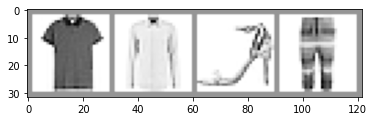

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 内置图片展示辅助函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # 未归一化
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# 从图片中创建一个网格，并展示它们
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## The Model

我们在这个例子中使用的模型是LeNet-5的一个变种--如果你看过这个系列的前几个视频，应该对它很熟悉。

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch 模型继承自 torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## Loss Function

在这个例子中，我们将使用一个交叉熵损失。为了演示，我们将创建一批假的输出和标签值，通过损失函数运行它们，并检查结果。

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: 损失函数希望数据是分批的，所以我们要创建4个批次的数据。
# 代表模型对给定输入的10个类别中每个类别的置信度

dummy_outputs = torch.rand(4, 10)
# 表示10个测试中的正确类别
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('这一批次的总损失： {}'.format(loss.item()))

tensor([[0.2712, 0.4674, 0.5883, 0.8846, 0.6150, 0.2307, 0.6500, 0.9596, 0.2869,
         0.1492],
        [0.3574, 0.2543, 0.0201, 0.5144, 0.7854, 0.2183, 0.9674, 0.6228, 0.1985,
         0.1773],
        [0.1609, 0.6773, 0.0123, 0.2058, 0.8442, 0.4827, 0.8952, 0.1710, 0.2615,
         0.3651],
        [0.0508, 0.2663, 0.0414, 0.1379, 0.1583, 0.3826, 0.6810, 0.4909, 0.4166,
         0.8216]])
tensor([1, 5, 3, 7])
这一批次的总损失： 2.4143130779266357


## Optimizer

在这个例子中，我们将使用简单的随机梯度下降法和动量。

尝试这种优化方案的一些变化可能会有所启发：

- 学习率决定了优化器的步骤的大小。就准确性和收敛时间而言，不同的学习率会对你的训练结果产生什么影响？

- 动量使优化器在多个步骤中向最强梯度的方向推进。改变这个值对你的结果有什么作用？

- 尝试一些不同的优化算法，如平均SGD、Adagrad或Adam。你的结果有什么不同？

In [7]:
# 优化器在 torch.optim 包中被指定
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

下面，我们有一个函数，执行一个训练世代。它从DataLoader中列举数据，并在循环的每一次传递中做以下工作：

- 从DataLoader中获取一批训练数据

- 将优化器的梯度清零

- 执行推理--也就是说，从模型中获得对一个输入批次的预测结果

- 计算该组预测的损失与数据集上的标签之间的关系

- 计算学习权重的后向梯度

- 告诉优化器执行一个学习步骤--即根据我们选择的优化算法，基于该批次的观察梯度调整模型的学习权重

- 它报告每1000个批次的损失。

- 最后，它报告过去1000批的每批平均损失，以便与验证运行进行比较。

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # 这里，我们使用enumerate(training_loader)而不是
    # iter(training_loader)，这样我们就可以跟踪批次的
    # 索引并做一些周期内的报告
    for i, data in enumerate(training_loader):
        # 每个数据实例都是 输入 + 标签对
        inputs, labels = data
        
        # 对每个批次归零梯度
        optimizer.zero_grad()
        
        # 对每个批次做预测
        outputs = model(inputs)
        
        # 计算损失和它的梯度
        loss = loss_fn(outputs, labels)